In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special, interpolate
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV as cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

import powerlaw

In [2]:
df = pd.read_pickle('../data/df.pickle')
df.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [3]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_20200601_20201116 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-17")].dropna()
df_20201117_20201216 = df[(df["started_at"] >= "2020-11-17") & (df["started_at"] < "2020-12-17")].dropna()
df_20201217_20201231 = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-01-01")].dropna()
df_2021 = df[(df["started_at"] >= "2021-01-01") & (df["started_at"] < "2022-01-01")].dropna()
df_2022 = df[(df["started_at"] >= "2022-01-01") & (df["started_at"] < "2023-01-01")].dropna()
df_2023 = df[(df["started_at"] >= "2023-01-01") & (df["started_at"] < "2023-10-01")].dropna()
df_2020 = df[(df["started_at"] >= "2020-01-01") & (df["started_at"] < "2021-01-01")].dropna()

In [4]:
def getNetworkAnalysis(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df = df.sort_values(by='start_station_name')

    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []
    distance_list = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # ユニークな駅のリストを取得
        # values.ravel('K')で多次元配列を1次元配列に変換
        unique_stations = pd.unique(df_tmp[['start_station_name', 'end_station_name']].values.ravel('K'))

        # node_listにノード数を追加
        node_list.append(len(unique_stations))

        # edge_listにエッジ数を追加
        df_tmp = df_tmp.drop_duplicates(subset=['start_station_name', 'end_station_name'])
        edge_list.append(len(df_tmp))

        # distance_listに平均距離を追加
        distance_list.append(df_tmp['distance'].mean())

        current_timestamp = next_timestamp

    return node_list, edge_list, timestamp

In [5]:
node_2020, edge_2020, timestamp_2020 = getNetworkAnalysis(df_2020)
node_2021, edge_2021, timestamp_2021 = getNetworkAnalysis(df_2021)
node_2022, edge_2022, timestamp_2022 = getNetworkAnalysis(df_2022)
node_2023, edge_2023, timestamp_2023 = getNetworkAnalysis(df_2023)

In [6]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

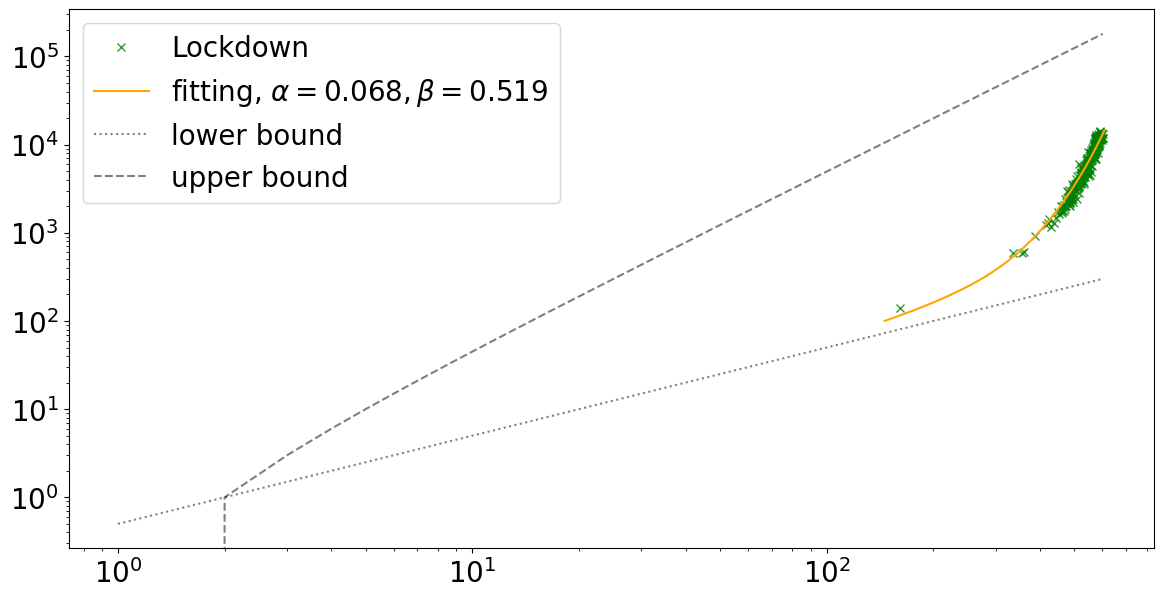

In [7]:
plt.figure(figsize=(14, 7))

N = node_2020
M = edge_2020

x = np.arange(1, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8, label="Lockdown")


Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[0.5,0.5])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

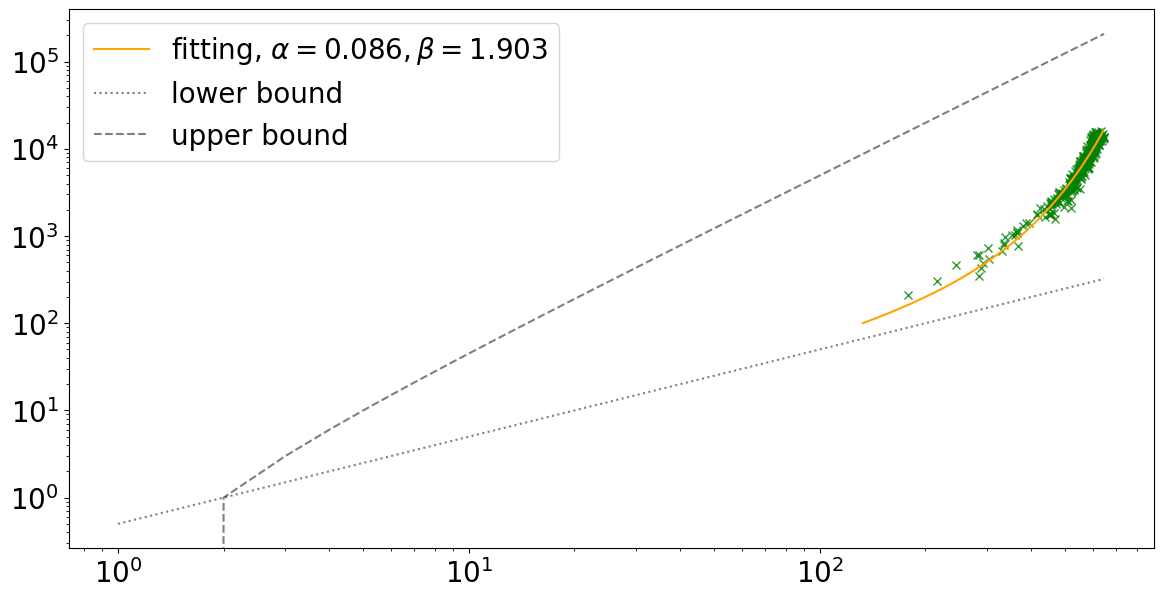

In [8]:
plt.figure(figsize=(14, 7))

N = node_2021
M = edge_2021

x = np.arange(1, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)


Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[0.5,0.5])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

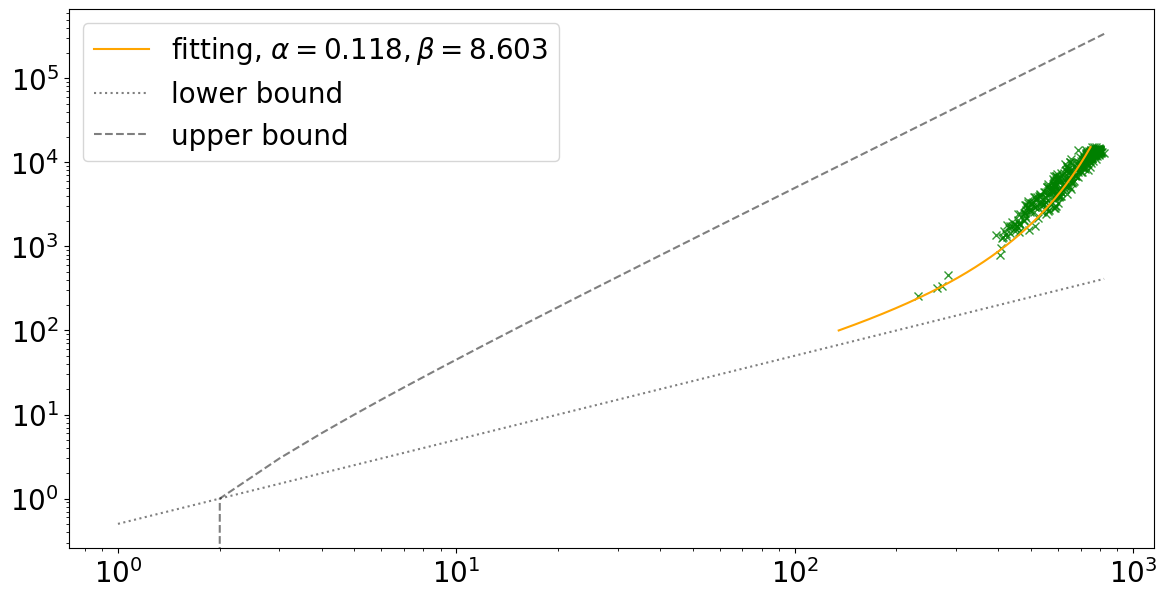

In [10]:
plt.figure(figsize=(14, 7))

N = node_2022
M = edge_2022

x = np.arange(1, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)


Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[1, 1])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()

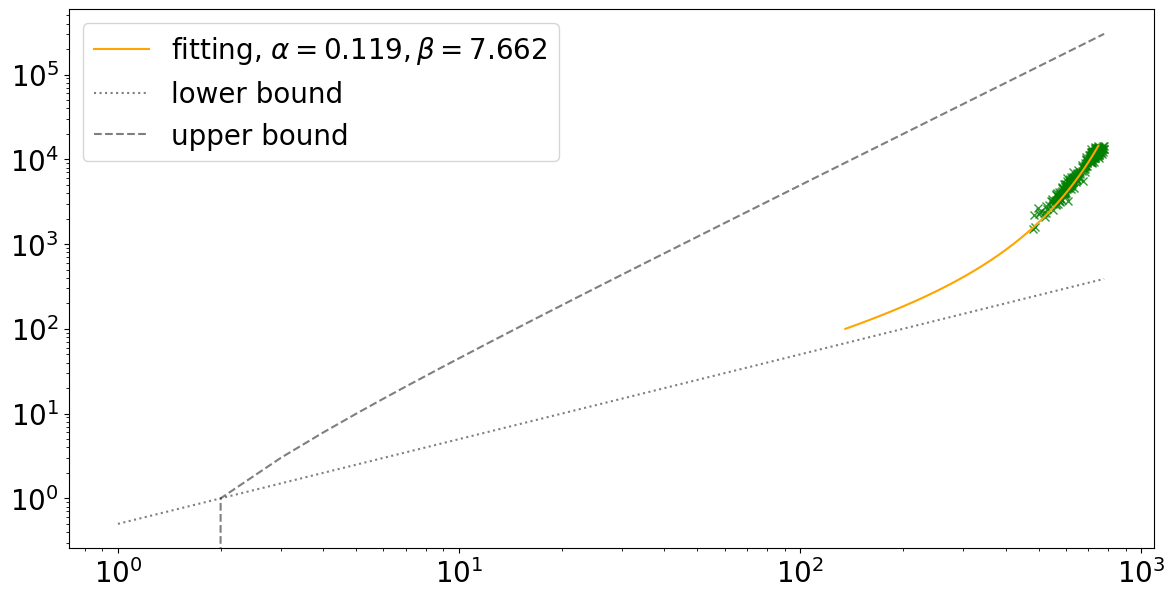

In [11]:
plt.figure(figsize=(14, 7))

N = node_2023
M = edge_2023

x = np.arange(1, np.max(N))
y = np.arange(100, np.max(M))
plt.plot(N, M, "x", c="green", alpha=0.8)


Np = 1652
params, _ = optimize.curve_fit(Model3_fixed, M, N, p0=[0.5,0.5])
alpha = params[0]
beta = params[1]

alpha = round(alpha, 3)
beta = round(beta, 3)

# plt.plot(Model1(y, kappa=kappa), y, label="model", c="red")
plt.plot(Model3(y), y, label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$", c="orange")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")


plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 20})
plt.show()